# Gymnasium Exploration

## Initialize Environment

In [1]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, sys

# A tool kit for RL
import gymnasium as gym
import matplotlib.pyplot as plt

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

# NES Emulator
from nes_py.wrappers import JoypadSpace

# A tool kit for visualization
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

%matplotlib inline

/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [2]:
# Add the src directory to the path
sys.path.append('../src')

In [16]:
"""Static action sets"""
# Actions for the simple right-only movement
RIGHT_ONLY = [0, 3, 6, 11, 14]

# Actions for the simple movement
SIMPLE_MOVEMENT = [0, 3, 6, 11, 14, 2, 4]

# Actions for the complex movement
COMPLEX_MOVEMENT = [0, 3, 6, 11, 14, 2, 4, 7, 12, 15, 5, 2]

In [4]:
# Create the Mario environment
env = gym.make("ALE/MarioBros-v5", render_mode="rgb_array", full_action_space=False)
state = env.reset()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [5]:
import gym
import numpy as np

class CustomActionWrapper(gym.ActionWrapper):
    def __init__(self, env, action_mapping):
        super(CustomActionWrapper, self).__init__(env)
        self.action_mapping = action_mapping
        self.action_space = gym.spaces.Discrete(len(action_mapping))  # Limit the action space
    def action(self, action):
        # print(f"Action requested: {action}")
        if action < len(self.action_mapping):
            mapped_action = self.action_mapping[action]
            # print(f"Mapped to original action: {mapped_action}")
            return mapped_action
        else:
            raise IndexError("Action index is out of range")

In [6]:
# Wrap the environment with the custom action wrapper
env = CustomActionWrapper(env, SIMPLE_MOVEMENT)

# Print environment information
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Discrete(7)
Observation space: Box(0, 255, (210, 160, 3), uint8)


In [7]:
# Print the limited action meanings
for i in range(env.action_space.n):
    print(f"Action {i}: {env.unwrapped.get_action_meanings()[i]}")


Action 0: NOOP
Action 1: FIRE
Action 2: UP
Action 3: RIGHT
Action 4: LEFT
Action 5: DOWN
Action 6: UPRIGHT


In [9]:
# Check if the action wrapper works as expected
for i in range(len(env.action_mapping)):
    print("-"*50)
    print(f"Testing action index: {i}")
    next_state, reward, done, trunc, info = env.step(i)
    print(f"Action {i} executed, mapped to original action {env.action_mapping[i]}")
    print(f"Action meaning: {env.unwrapped.get_action_meanings()[env.action_mapping[i]]}")
    env.reset()

--------------------------------------------------
Testing action index: 0
Action 0 executed, mapped to original action 0
Action meaning: NOOP
--------------------------------------------------
Testing action index: 1
Action 1 executed, mapped to original action 3
Action meaning: RIGHT
--------------------------------------------------
Testing action index: 2
Action 2 executed, mapped to original action 6
Action meaning: UPRIGHT
--------------------------------------------------
Testing action index: 3
Action 3 executed, mapped to original action 11
Action meaning: RIGHTFIRE
--------------------------------------------------
Testing action index: 4
Action 4 executed, mapped to original action 14
Action meaning: UPRIGHTFIRE
--------------------------------------------------
Testing action index: 5
Action 5 executed, mapped to original action 2
Action meaning: UP
--------------------------------------------------
Testing action index: 6
Action 6 executed, mapped to original action 4
Acti

In [10]:
# Test all the actions
for i in range(env.action_space.n):
    print("-"*50)
    print(f"Testing action index: {i}")
    next_state, reward, done, trunc, info = env.step(i)
    print(f"Action {i} executed, mapped to original action {env.action_mapping[i]}")
    print(f"Action meaning: {env.unwrapped.get_action_meanings()[env.action_mapping[i]]}")
    env.reset()

--------------------------------------------------
Testing action index: 0
Action 0 executed, mapped to original action 0
Action meaning: NOOP
--------------------------------------------------
Testing action index: 1
Action 1 executed, mapped to original action 3
Action meaning: RIGHT
--------------------------------------------------
Testing action index: 2
Action 2 executed, mapped to original action 6
Action meaning: UPRIGHT
--------------------------------------------------
Testing action index: 3
Action 3 executed, mapped to original action 11
Action meaning: RIGHTFIRE
--------------------------------------------------
Testing action index: 4
Action 4 executed, mapped to original action 14
Action meaning: UPRIGHTFIRE
--------------------------------------------------
Testing action index: 5
Action 5 executed, mapped to original action 2
Action meaning: UP
--------------------------------------------------
Testing action index: 6
Action 6 executed, mapped to original action 4
Acti

In [11]:
# Render the environment
for i in range(env.action_space.n):
    print("-"*50)
    next_state, reward, done, trunc, info = env.step(i)
    print(f"Action taken: {env.unwrapped.get_action_meanings()[env.action_mapping[i]]}")
    print(f"Next state: {next_state.shape}")
    print(f"Reward: {reward}")
    print(f"Done?: {done}")
    print(f"Info: {info}")

--------------------------------------------------
Action taken: NOOP
Next state: (210, 160, 3)
Reward: 0.0
Done?: False
Info: {'lives': 5, 'episode_frame_number': 4, 'frame_number': 88}
--------------------------------------------------
Action taken: RIGHT
Next state: (210, 160, 3)
Reward: 0.0
Done?: False
Info: {'lives': 5, 'episode_frame_number': 8, 'frame_number': 92}
--------------------------------------------------
Action taken: UPRIGHT
Next state: (210, 160, 3)
Reward: 0.0
Done?: False
Info: {'lives': 5, 'episode_frame_number': 12, 'frame_number': 96}
--------------------------------------------------
Action taken: RIGHTFIRE
Next state: (210, 160, 3)
Reward: 0.0
Done?: False
Info: {'lives': 5, 'episode_frame_number': 16, 'frame_number': 100}
--------------------------------------------------
Action taken: UPRIGHTFIRE
Next state: (210, 160, 3)
Reward: 0.0
Done?: False
Info: {'lives': 5, 'episode_frame_number': 20, 'frame_number': 104}
--------------------------------------------

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML
import numpy as np

def display_frames_as_gif(frames, interval=50):
    """
    Displays a list of frames as a gif, with controls.
    """
    fig, ax = plt.subplots()
    patch = ax.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        return patch,

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=interval, blit=True)

    # Save animation as HTML with no `clear_temp` argument
    html = anim.to_html5_video()
    display(HTML(html))
    plt.close(fig)  # Close the figure to prevent it from displaying statically

{'lives': 5, 'episode_frame_number': 4, 'frame_number': 4116}
{'lives': 5, 'episode_frame_number': 8, 'frame_number': 4120}
{'lives': 5, 'episode_frame_number': 12, 'frame_number': 4124}
{'lives': 5, 'episode_frame_number': 16, 'frame_number': 4128}
{'lives': 5, 'episode_frame_number': 20, 'frame_number': 4132}
{'lives': 5, 'episode_frame_number': 24, 'frame_number': 4136}
{'lives': 5, 'episode_frame_number': 28, 'frame_number': 4140}
{'lives': 5, 'episode_frame_number': 32, 'frame_number': 4144}
{'lives': 5, 'episode_frame_number': 36, 'frame_number': 4148}
{'lives': 5, 'episode_frame_number': 40, 'frame_number': 4152}
{'lives': 5, 'episode_frame_number': 44, 'frame_number': 4156}
{'lives': 5, 'episode_frame_number': 48, 'frame_number': 4160}
{'lives': 5, 'episode_frame_number': 52, 'frame_number': 4164}
{'lives': 5, 'episode_frame_number': 56, 'frame_number': 4168}
{'lives': 5, 'episode_frame_number': 60, 'frame_number': 4172}
{'lives': 5, 'episode_frame_number': 64, 'frame_number': 

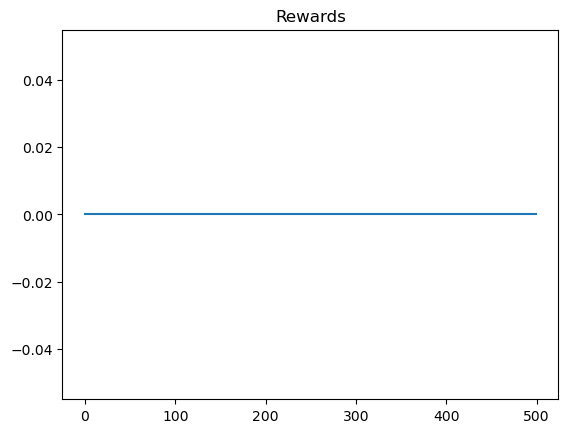

Sum of rewards is  0.0


In [15]:
# Environment reset and frame capture
observation = env.reset()
r = []
infos = []
MAX_STEPS = 500
frames = []

for step in range(MAX_STEPS):
    # Render into buffer
    frame = env.render()
    frames.append(frame)

    observation, reward, done, trunc, info = env.step(env.action_space.sample())
    infos.append(info)
    print(info)
    r.append(reward)
    if done:
        break
        
r = np.array(r)

# Display frames as GIF
display_frames_as_gif(frames)

# Plot rewards
plt.plot(r)
plt.title('Rewards')
plt.show()

print('Sum of rewards is ', r.sum())

## Preprocess Data

In the game of Mario, color information is not important. We can convert the image to grayscale to reduce the dimensionality of the observation space.

We use Wrappers to preprocess the data before feeding it to the agent.

In [ ]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """
        Initialize the SkipFrame wrapper.
        
        Parameters:
        env (gym.Env): The environment to wrap.
        skip (int): The number of frames to skip.
        """
        pass


    def step(self, action):
        """
        Repeat the action for the specified number of frames and sum the reward.

        Parameters:
        action: The action to perform on the environment.

        Returns:
        obs: The observation after performing the action.
        total_reward: The sum of rewards obtained from repeated actions.
        done: Whether the episode has ended.
        trunk: Additional information (typically 'truncated' status in Gym).
        info: Additional info from the environment.
        """
        pass


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Initialize the GrayScaleObservation wrapper.
        
        Parameters:
        env (gym.Env): The environment to wrap.
        """
        pass
    
    def permute_orientation(self, observation):
        """
        Permute the observation array from [H, W, C] to [C, H, W].
        
        Parameters:
        observation (numpy.ndarray): The original observation array.
        
        Returns:
        observation (torch.Tensor): The permuted observation tensor.
        """
        pass

    def observation(self, observation):
        """
        Convert the observation to grayscale.
        
        Parameters:
        observation (numpy.ndarray): The original observation array.
        
        Returns:
        observation (torch.Tensor): The grayscale observation tensor.
        """
        pass


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        """
        Initialize the ResizeObservation wrapper.
        
        Parameters:
        env (gym.Env): The environment to wrap.
        shape (int or tuple): The desired shape for the observation.
        """
        pass


    def observation(self, observation):
        """
        Resize the observation to the specified shape.
        
        Parameters:
        observation (numpy.ndarray): The original observation array.
        
        Returns:
        observation (torch.Tensor): The resized observation tensor.
        """
        pass


After applying the above wrappers to the environment, the final wrapped state consists of 4 gray-scaled consecutive frames stacked together, as shown above in the image on the left. Each time Mario makes an action, the environment responds with a state of this structure. The structure is represented by a 3-D array of size [4, 84, 84].

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import FrameStack

# import wrappers from ../src/env/wrappers.py
from env.wrappers import SkipFrame, GrayScaleObservation, ResizeObservation

# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)

env = FrameStack(env, num_stack=4)

# Print the observation space
print(f"Observation space after preprocessing: {env.observation_space}")

## Agent

We create a class Mario to represent our agent in the game. Mario should be able to:

- Act according to the optimal action policy based on the current state (of the environment).

- Remember experiences. Experience = (current state, current action, reward, next state). Mario caches and later recalls his experiences to update his action policy.

- Learn a better action policy over time

In [ ]:
class Mario:
    def __init__():
        pass

    def act(self, state):
        """Given a state, choose an epsilon-greedy action"""
        pass

    def cache(self, experience):
        """Add the experience to memory"""
        pass

    def recall(self):
        """Sample experiences from memory"""
        pass

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        pass